<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/6_Local_MLP_NoClassWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastai==2.2.5

In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preprocessing

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)

In [5]:
def get_numerical_col(data, categorical_col):
  numerical_col = []
  for col in data.columns:
    if col not in categorical_col and col != 'isFraud':
      numerical_col.append(col)
  return numerical_col

cols = mf.get_col(data)
categorical_col = data.select_dtypes(include=['object']).columns.tolist()
numerical_col = get_numerical_col(data, categorical_col)

In [6]:
from fastai.tabular.all import *
fasted = TabularPandas(data, procs=[Categorify],cat_names = categorical_col,cont_names = numerical_col,y_names='isFraud')

In [7]:
X_train, y_train = fasted.xs, fasted.ys.values.ravel()

In [8]:
categorical_col_toemb = []
one_hot_encode = []
for col in categorical_col:
  if X_train[col].max() > 7:
    categorical_col_toemb.append(col)
  else:
    one_hot_encode.append(col)

X_train = pd.get_dummies(X_train, columns=one_hot_encode)
cols = mf.get_col(X_train)
numerical_col = get_numerical_col(X_train, categorical_col_toemb)

In [9]:
n_clients = 5
def mergeResult(X, y, col_name):
  y_res = y.reshape(np.shape(y)[0],1)
  data = np.concatenate((X,y_res), axis = 1)
  col_name.append('isFraud')
  dataset = pd.DataFrame(data=data, columns=col_name)
  col_name.remove('isFraud')
  return dataset

def splitData(data, n_clients):
  X = {}
  y = {}
  shuffled = data.sample(frac=1)
  result = np.array_split(shuffled, n_clients) 
  i = 0
  for dataset in result:
    y[i] = dataset['isFraud']
    X[i] = dataset.drop(columns=['isFraud'])
    i += 1
  return X, y

data = mergeResult(X_train, y_train, cols)
X, y = splitData(data, n_clients)

## Train validation test split

Splitto il dataset in train, validation e test set. 

In [10]:
def overSampling(X, y, frac_over=0.3):
  from imblearn.over_sampling import SMOTE
  sm = SMOTE(sampling_strategy=frac_over, random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)  
  return X_sm, y_sm


def underSampling(X, y, frac_under=0.1):
  from imblearn.under_sampling import RandomUnderSampler 
  us = RandomUnderSampler(sampling_strategy=frac_under, random_state=42)
  X_us, y_us = us.fit_resample(X, y)
  return X_us, y_us

In [11]:
X_train = {}
y_train = {}
X_test = {}
X_val = {}
y_test = {}
y_val = {}
for i in range(n_clients):
  X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size = 0.2)
  X_train[i], y_train[i]  = underSampling(X_train[i], y_train[i])
  X_train[i], y_train[i] = overSampling(X_train[i], y_train[i])
  X_train[i], X_val[i], y_train[i], y_val[i] = train_test_split(X_train[i], y_train[i], test_size=0.25, random_state=42)

# Neural Network

Kaggle tutorial https://www.kaggle.com/colinmorris/embedding-layers

Implementation: https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding

**************************************************************************************************************
Training model 0
Epoch 1/30
64/64 [==============================] - 9s 75ms/step - loss: 0.7707 - accuracy: 0.6563 - recall: 0.5699 - precision: 0.3600 - val_loss: 0.6576 - val_accuracy: 0.6430 - val_recall: 0.8556 - val_precision: 0.3759
Epoch 2/30
64/64 [==============================] - 3s 40ms/step - loss: 0.4448 - accuracy: 0.8031 - recall: 0.4923 - precision: 0.5885 - val_loss: 0.6043 - val_accuracy: 0.7964 - val_recall: 0.6566 - val_precision: 0.5444
Epoch 3/30
64/64 [==============================] - 3s 40ms/step - loss: 0.4092 - accuracy: 0.8221 - recall: 0.4773 - precision: 0.6626 - val_loss: 0.5542 - val_accuracy: 0.8206 - val_recall: 0.5340 - val_precision: 0.6250
Epoch 4/30
64/64 [==============================] - 3s 40ms/step - loss: 0.3905 - accuracy: 0.8302 - recall: 0.4758 - precision: 0.7022 - val_loss: 0.5186 - val_accuracy: 0.8169 - val_recall: 0.5777 - va

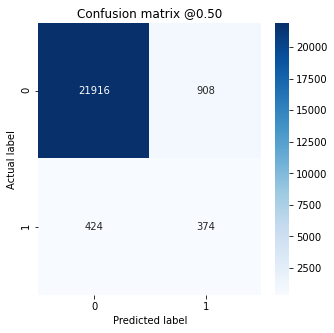

AUC:  0.8496442374337525
Average precision:  0.36788247218897113
F1 score:  0.3596153846153846
Recall:  0.46867167919799496
Precision:  0.2917316692667707
**************************************************************************************************************
**************************************************************************************************************
Training model 1
Epoch 1/30
62/62 [==============================] - 7s 67ms/step - loss: 0.6419 - accuracy: 0.6873 - recall: 0.6189 - precision: 0.3969 - val_loss: 0.6678 - val_accuracy: 0.6608 - val_recall: 0.8223 - val_precision: 0.3903
Epoch 2/30
62/62 [==============================] - 2s 38ms/step - loss: 0.4353 - accuracy: 0.8112 - recall: 0.4797 - precision: 0.6151 - val_loss: 0.6127 - val_accuracy: 0.8034 - val_recall: 0.6389 - val_precision: 0.5677
Epoch 3/30
62/62 [==============================] - 2s 40ms/step - loss: 0.4004 - accuracy: 0.8267 - recall: 0.4610 - precision: 0.6867 - val_loss: 0.5944 - val

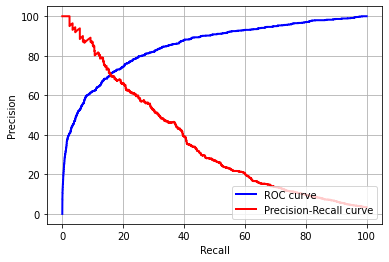

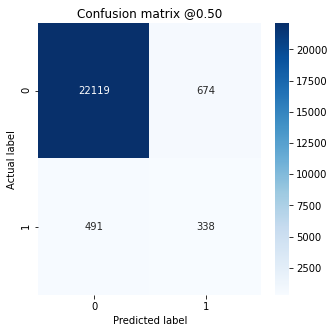

AUC:  0.8430033250955247
Average precision:  0.3399012099066675
F1 score:  0.3671917436175991
Recall:  0.4077201447527141
Precision:  0.3339920948616601
**************************************************************************************************************
**************************************************************************************************************
Training model 2
Epoch 1/30
64/64 [==============================] - 8s 71ms/step - loss: 0.6377 - accuracy: 0.6887 - recall: 0.6187 - precision: 0.3974 - val_loss: 0.7604 - val_accuracy: 0.2630 - val_recall: 0.9935 - val_precision: 0.2352
Epoch 2/30
64/64 [==============================] - 3s 39ms/step - loss: 0.4310 - accuracy: 0.8135 - recall: 0.5044 - precision: 0.6238 - val_loss: 0.6099 - val_accuracy: 0.7424 - val_recall: 0.6692 - val_precision: 0.4553
Epoch 3/30
64/64 [==============================] - 3s 40ms/step - loss: 0.3940 - accuracy: 0.8300 - recall: 0.4681 - precision: 0.6971 - val_loss: 0.5442 - val_a

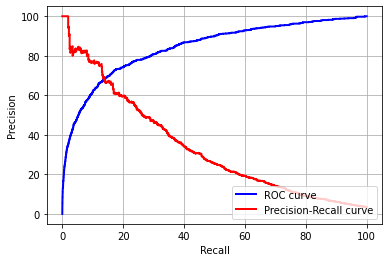

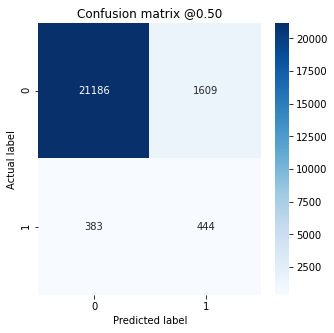

AUC:  0.8368149106713988
Average precision:  0.3429211782711781
F1 score:  0.30833333333333335
Recall:  0.5368802902055623
Precision:  0.21626887481734047
**************************************************************************************************************
**************************************************************************************************************
Training model 3
Epoch 1/30
64/64 [==============================] - 8s 72ms/step - loss: 0.6637 - accuracy: 0.6841 - recall: 0.6052 - precision: 0.3895 - val_loss: 0.6973 - val_accuracy: 0.4883 - val_recall: 0.9174 - val_precision: 0.2984
Epoch 2/30
64/64 [==============================] - 3s 40ms/step - loss: 0.4361 - accuracy: 0.8073 - recall: 0.4899 - precision: 0.5964 - val_loss: 0.6662 - val_accuracy: 0.6322 - val_recall: 0.8854 - val_precision: 0.3719
Epoch 3/30
64/64 [==============================] - 3s 41ms/step - loss: 0.3986 - accuracy: 0.8212 - recall: 0.4744 - precision: 0.6664 - val_loss: 0.6260 - val

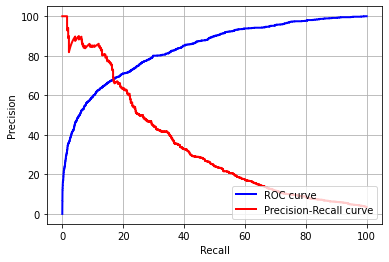

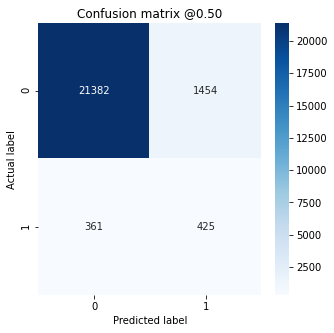

AUC:  0.8588634770241353
Average precision:  0.33939093249505975
F1 score:  0.31894934333958724
Recall:  0.5407124681933843
Precision:  0.2261841405002661
**************************************************************************************************************
**************************************************************************************************************
Training model 4
Epoch 1/30
64/64 [==============================] - 8s 78ms/step - loss: 0.6772 - accuracy: 0.6719 - recall: 0.6049 - precision: 0.3794 - val_loss: 0.6110 - val_accuracy: 0.8143 - val_recall: 0.4416 - val_precision: 0.6446
Epoch 2/30
64/64 [==============================] - 3s 44ms/step - loss: 0.4422 - accuracy: 0.8082 - recall: 0.4860 - precision: 0.6066 - val_loss: 0.5538 - val_accuracy: 0.7981 - val_recall: 0.1545 - val_precision: 0.8531
Epoch 3/30
64/64 [==============================] - 3s 43ms/step - loss: 0.3977 - accuracy: 0.8287 - recall: 0.4727 - precision: 0.6908 - val_loss: 0.5012 - val

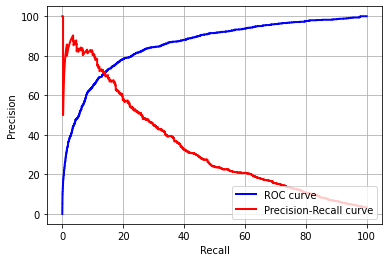

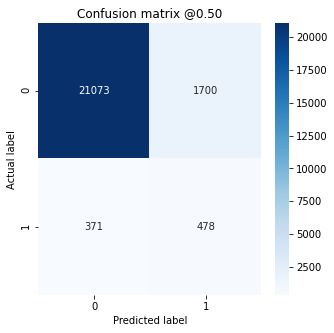

AUC:  0.8352368697314103
Average precision:  0.34290017503690773
F1 score:  0.31582424843078954
Recall:  0.5630153121319199
Precision:  0.2194674012855831
**************************************************************************************************************


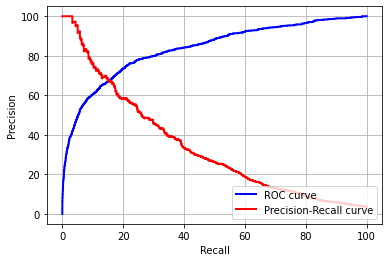

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import f1_score, recall_score, precision_score

for i in range(n_clients):
  keras.backend.clear_session()
  def get_keras_dataset(X, cols):
    df = pd.DataFrame(data=X, columns=cols)
    X = {str(col) : np.array(df[col]) for col in df.columns}
    return X

  categorical_input = []
  numerical_input = []
  embeddings = []
  embedding_layer_names = []
  for col in categorical_col_toemb:
  # for col in categorical_col:
      _input = layers.Input(shape=[1], name=col)
      _embed = layers.Embedding(fasted[col].max() + 1, 3, name=col+'_emb')(_input)
      categorical_input.append(_input)
      embeddings.append(_embed)
      embedding_layer_names.append(col+'_emb')
      
  # Simple inputs for the numeric features
  for col in numerical_col:
      numeric_input = layers.Input(shape=(1,), name=col)
      numerical_input.append(numeric_input)
      
  # Merge the numeric inputs
  merged_num_inputs = layers.concatenate(numerical_input)

  # Merge embedding and use a Droput to prevent overfittting
  merged_inputs = layers.concatenate(embeddings)
  spatial_dropout = layers.SpatialDropout1D(0.6)(merged_inputs) # 0.2
  flat_embed = layers.Flatten()(spatial_dropout)

  # Merge embedding and numeric features
  all_features = layers.concatenate([flat_embed, merged_num_inputs])

  # MLP for classification
  x = layers.Dense(360, activation=tf.keras.activations.gelu)(all_features) 
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.4)(x)

  # Final model
  output = layers.Dense(1, activation='sigmoid')(x)
  model = models.Model(inputs=categorical_input + numerical_input, outputs=output)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

  print('**************************************************************************************************************')
  print('Training model', i)
  history = model.fit(get_keras_dataset(X_train[i], cols), y_train[i], epochs=30, batch_size=512, validation_data=(get_keras_dataset(X_val[i], cols),y_val[i]),verbose=1,shuffle = True)# , class_weight = {0: 0.5, 1: 4})

  y_pred = model.predict(get_keras_dataset(X_test[i], cols))

  mf.plot_cm(y_test[i], y_pred, 'Blues')
  mf.plot_roc("ROC curve", y_test[i], y_pred, color='blue')
  mf.plot_ap('Precision-Recall curve', y_test[i], y_pred, color = 'red')

  y_predicted = []
  for prob in y_pred:
    if prob >= 0.5:
      y_predicted.append(1)
    else:
      y_predicted.append(0)

  print('F1 score: ',f1_score(y_test[i], y_predicted, average="binary"))
  print('Recall: ', recall_score(y_test[i], y_predicted, average='binary'))
  print('Precision: ', precision_score(y_test[i], y_predicted,  average='binary'))
  print('**************************************************************************************************************')
